## Generate a PSD plot framework for future plots (this one is based on our first buoy experiment).

In [118]:
#Purisa Jasmine Simmons
#August 2018

#Overview: PSD for E3 (Buoy_Calibrator1), trying to generate a PSD plot (framework for future plots).
#Based on Method V of this paper: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

#First, parse the data from the .CSV file.
#This data comes from a controlled experiment (CE3), so we are assuming that 
#all of the vertical accelerations are contained in IMUA2.

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import mpld3
import folium
import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline


In [177]:
ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)

In [178]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    



In [179]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)


https://surf.smartfin.org/ride/14827
https://surf.smartfin.org/media/201807/google_117589279598321562176_000666D321BE_180723164430_Ocean.CSV
                               Time  Temperature 1  Calibrated Temperature 1  \
UTC                                                                            
2018-07-23 16:44:42.467  1370665472            493                    30.812   
2018-07-23 16:44:48.487  1370671492            496                    31.000   
2018-07-23 16:44:54.507  1370677512            499                    31.188   
2018-07-23 16:45:00.528  1370683533            500                    31.250   
2018-07-23 16:45:06.549  1370689554            500                    31.250   
2018-07-23 16:45:12.569  1370695574            502                    31.375   
2018-07-23 16:45:18.591  1370701596            502                    31.375   
2018-07-23 16:45:24.612  1370707617            504                    31.500   
2018-07-23 16:45:30.634  1370713639            505         

## Make a copy of the original motion_df dataframe

In [180]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

#print(saved_copy_motion_df)

## Calcualting time_elapseds, time_offsets and creating IMU1, IMU2, and IMU3 raw data lists

In [199]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3'])

#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []

imu1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu1_array = []

imu2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu2_array = []

imu3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu3_array = []


#Get all the times and imus where time, imu1, imu2, and imu3 are NOT nan values:
for t,x,y,z in zip(time_array_nans, imu1_array_nans, imu2_array_nans, imu3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu1_array.append(x)
        imu2_array.append(y)
        imu3_array.append(z)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    
    #print(prev, " ", after)
    #print(after - prev)
    
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1


##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu1_array[-1])
del(imu2_array[-1])
del(imu3_array[-1])
    
print(len(time_e_list))
print(len(time_o_list))
print(len(imu1_array))
print(len(imu2_array))
print(len(imu3_array))



#print(time_o_list)
#print(time_e_list)

#for x in imu2_array:
#    print(x)

23432
23432
23432
23432
23432


## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])

In [200]:
#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = -9.80665

# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        new_a = a / g_const * gravity
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        #new_a = a + 9.81 (??)
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu1_array) #new units in m/s^2
imu2_array = convert_acc_units(imu2_array) #new units in m/s^2
imu3_array = convert_acc_units(imu3_array) #new units in m/s^2

##To check:
#for x in imu1_array:
#    print(x)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
print(len(time_e_list))
print(len(imu2_array))



23432
23432
23432


## PSD Step 1: Seperate each of the subexperiments into its own acc lists

In [201]:
for x in time_e_array:
    print(x)

0.0
0.033
0.066
0.099
0.132
0.165
0.198
0.231
0.265
0.297
0.331
0.364
0.397
0.43
0.463
0.496
0.529
0.563
0.595
0.629
0.662
0.695
0.728
0.761
0.794
0.827
0.861
0.893
0.926
0.96
0.993
1.026
1.059
1.092
1.125
1.159
1.191
1.224
1.258
1.291
1.324
1.357
1.39
1.423
1.456
1.489
1.523
1.555
1.589
1.622
1.655
1.688
1.721
1.754
1.787
1.821
1.853
1.887
1.92
1.953
1.986
2.019
2.052
2.085
2.119
2.151
2.184
2.218
2.251
2.284
2.317
2.35
2.383
2.416
2.449
2.482
2.515
2.549
2.582
2.615
2.648
2.681
2.714
2.747
2.78
2.813
2.846
2.88
2.913
2.946
2.979
3.012
3.045
3.079
3.111
3.144
3.178
3.211
3.244
3.277
3.31
3.343
3.376
3.409
3.443
3.475
3.498
3.531
3.564
3.597
3.63
3.663
3.696
3.729
3.762
3.795
3.829
3.862
3.895
3.928
3.961
3.994
4.027
4.06
4.093
4.127
4.16
4.193
4.226
4.259
4.292
4.325
4.359
4.391
4.424
4.458
4.491
4.524
4.557
4.59
4.623
4.656
4.689
4.723
4.755
4.789
4.822
4.855
4.888
4.921
4.954
4.987
5.02
5.053
5.087
5.12
5.153
5.186
5.219
5.252
5.285
5.319
5.351
5.385
5.417
5.451
5.484
5.517
5.568
5.

85.72
85.753
85.786
85.819
85.852
85.885
85.919
85.952
85.985
86.018
86.051
86.084
86.117
86.15
86.183
86.2275
86.272
86.305
86.338
86.371
86.404
86.437
86.47
86.503
86.537
86.569
86.603
86.636
86.669
86.702
86.735
86.768
86.801
86.834
86.867
86.901
86.934
86.967
87.0
87.033
87.066
87.099
87.132
87.165
87.199
87.232
87.265
87.298
87.331
87.364
87.397
87.43
87.463
87.497
87.529
87.563
87.596
87.629
87.662
87.695
87.728
87.761
87.795
87.827
87.861
87.894
87.927
87.96
87.993
88.026
88.059
88.093
88.125
88.158
88.192
88.225
88.258
88.291
88.324
88.357
88.391
88.423
88.456
88.49
88.523
88.556
88.589
88.622
88.655
88.688
88.721
88.755
88.787
88.821
88.854
88.887
88.92
88.953
88.986
89.019
89.053
89.085
89.119
89.152
89.185
89.218
89.251
89.284
89.317
89.351
89.383
89.416
89.45
89.483
89.516
89.549
89.582
89.615
89.648
89.681
89.878
90.076
90.275
90.473
90.672
90.871
91.08
91.279
91.478
91.677
91.875
92.073
92.272
92.471
92.68
92.879
93.078
93.277
93.309
93.342
93.376
93.409
93.442
93.475
93.

160.233
160.267
160.3
160.333
160.366
160.399
160.432
160.465
160.499
160.531
160.565
160.598
160.631
160.664
160.697
160.73
160.763
160.797
160.829
160.8735
160.918
160.951
160.984
161.017
161.05
161.083
161.116
161.149
161.183
161.216
161.249
161.282
161.315
161.348
161.381
161.414
161.447
161.481
161.513
161.547
161.58
161.613
161.646
161.679
161.712
161.745
161.795
161.845
161.878
161.911
161.944
161.977
162.01
162.043
162.091
162.14
162.172
162.205
162.238
162.271
162.304
162.337
162.37
162.403
162.436
162.469
162.503
162.535
162.568
162.602
162.635
162.668
162.701
162.734
162.767
162.8
162.833
162.866
162.899
162.932
162.965
162.998
163.031
163.064
163.097
163.13
163.164
163.196
163.229
163.262
163.295
163.328
163.361
163.394
163.427
163.46
163.493
163.527
163.559
163.592
163.626
163.659
163.692
163.725
163.758
163.791
163.824
163.857
163.907
163.957
163.99
164.023
164.056
164.089
164.122
164.155
164.188
164.221
164.255
164.288
164.321
164.354
164.387
164.42
164.453
164.486
164.5

227.153
227.186
227.219
227.252
227.285
227.318
227.351
227.384
227.417
227.45
227.483
227.516
227.55
227.582
227.616
227.649
227.682
227.715
227.748
227.781
227.814
227.847
227.88
227.914
227.947
227.98
228.013
228.046
228.079
228.112
228.145
228.178
228.211
228.244
228.277
228.32
228.342
228.375
228.408
228.441
228.474
228.507
228.54
228.574
228.606
228.64
228.673
228.706
228.739
228.772
228.805
228.838
228.871
228.904
228.938
228.971
229.004
229.037
229.07
229.103
229.136
229.169
229.202
229.235
229.269
229.302
229.335
229.368
229.401
229.434
229.468
229.5
229.533
229.566
229.599
229.632
229.665
229.698
229.731
229.764
229.797
229.831
229.863
229.896
229.93
229.963
229.996
230.029
230.062
230.095
230.128
230.161
230.194
230.227
230.261
230.294
230.327
230.36
230.393
230.426
230.459
230.492
230.525
230.57
230.614
230.647
230.68
230.713
230.746
230.779
230.812
230.845
230.879
230.912
230.945
230.978
231.011
231.044
231.077
231.11
231.143
231.177
231.209
231.242
231.275
231.308
231.341

340.636
340.669
340.703
340.736
340.769
340.802
340.835
340.868
340.901
340.935
340.967
341.0
341.034
341.067
341.1
341.133
341.166
341.199
341.232
341.265
341.298
341.331
341.365
341.398
341.431
341.464
341.497
341.53
341.563
341.596
341.629
341.663
341.696
341.729
341.762
341.795
341.828
341.861
341.894
341.927
341.961
341.993
342.027
342.06
342.093
342.126
342.159
342.192
342.225
342.259
342.291
342.325
342.358
342.391
342.424
342.457
342.49
342.523
342.556
342.589
342.623
342.656
342.689
342.721
342.754
342.787
342.82
342.853
342.886
342.92
342.952
342.985
343.018
343.051
343.084
343.117
343.15
343.183
343.216
343.249
343.282
343.315
343.349
343.382
343.415
343.448
343.481
343.514
343.547
343.58
343.613
343.647
343.68
343.713
343.746
343.779
343.812
343.845
343.878
343.911
343.945
343.977
344.011
344.044
344.077
344.11
344.143
344.176
344.209
344.243
344.2865
344.331
344.364
344.397
344.43
344.463
344.496
344.529
344.562
344.595
344.629
344.662
344.695
344.728
344.761
344.794
344.8

414.759
414.793
414.825
414.859
414.892
414.925
414.976
415.02
415.053
415.086
415.119
415.152
415.185
415.235
415.285
415.318
415.351
415.384
415.417
415.45
415.483
415.517
415.549
415.583
415.616
415.649
415.682
415.715
415.748
415.781
415.815
415.847
415.88
415.914
415.947
415.98
416.013
416.046
416.079
416.112
416.145
416.178
416.211
416.245
416.278
416.311
416.344
416.377
416.41
416.443
416.476
416.509
416.543
416.576
416.609
416.642
416.675
416.708
416.741
416.774
416.807
416.841
416.873
416.907
416.94
416.973
417.006
417.039
417.072
417.105
417.139
417.171
417.205
417.238
417.271
417.304
417.337
417.37
417.403
417.437
417.469
417.5135
417.558
417.591
417.624
417.657
417.69
417.723
417.756
417.789
417.823
417.856
417.889
417.922
417.955
417.988
418.021
418.054
418.087
418.12
418.154
418.187
418.22
418.253
418.286
418.319
418.352
418.385
418.418
418.451
418.485
418.518
418.551
418.584
418.617
418.65
418.683
418.733
418.782
418.816
418.849
418.882
418.915
418.948
418.981
419.015
41

563.471
563.504
563.537
563.571
563.603
563.637
563.67
563.703
563.736
563.769
563.802
563.835
563.869
563.901
563.934
563.968
564.001
564.034
564.067
564.1
564.133
564.167
564.199
564.232
564.266
564.299
564.332
564.365
564.398
564.431
564.464
564.497
564.53
564.563
564.597
564.63
564.663
564.696
564.729
564.762
564.795
564.829
564.861
564.894
564.928
564.961
564.994
565.027
565.06
565.093
565.127
565.159
565.192
565.226
565.259
565.292
565.325
565.358
565.391
565.424
565.457
565.488
565.521
565.555
565.587
565.621
565.654
565.687
565.72
565.753
565.786
565.819
565.853
565.885
565.918
565.952
565.985
566.018
566.051
566.084
566.117
566.151
566.183
566.216
566.25
566.283
566.316
566.349
566.382
566.415
566.448
566.481
566.514
566.547
566.581
566.614
566.647
566.68
566.713
566.746
566.779
566.813
566.845
566.878
566.912
566.945
566.978
567.011
567.044
567.077
567.11
567.143
567.177
567.209
567.243
567.276
567.309
567.342
567.375
567.408
567.441
567.475
567.507
567.541
567.563
567.596
56

644.573
644.605
644.638
644.672
644.705
644.738
644.771
644.804
644.837
644.871
644.903
644.936
644.97
645.003
645.036
645.069
645.102
645.135
645.168
645.201
645.235
645.267
645.301
645.334
645.367
645.4
645.433
645.466
645.499
645.533
645.565
645.598
645.632
645.665
645.698
645.731
645.764
645.797
645.831
645.863
645.896
645.93
645.963
645.996
646.029
646.062
646.095
646.128
646.161
646.194
646.227
646.261
646.294
646.327
646.36
646.393
646.426
646.459
646.492
646.525
646.559
646.592
646.625
646.658
646.691
646.724
646.757
646.79
646.823
646.857
646.889
646.923
646.956
646.989
647.022
647.055
647.088
647.121
647.155
647.187
647.21
647.243
647.276
647.309
647.342
647.375
647.408
647.441
647.475
647.507
647.541
647.574
647.607
647.64
647.673
647.706
647.739
647.772
647.805
647.839
647.872
647.905
647.938
647.971
648.004
648.037
648.07
648.103
648.137
648.169
648.203
648.236
648.269
648.302
648.335
648.368
648.401
648.435
648.467
648.501
648.534
648.567
648.6
648.633
648.666
648.699
648

779.906
779.939
779.972
780.005
780.039
780.071
780.104
780.138
780.171
780.204
780.237
780.27
780.303
780.336
780.369
780.403
780.435
780.469
780.502
780.535
780.568
780.601
780.634
780.667
780.7
780.733
780.767
780.8
780.833
780.866
780.899
780.932
780.965
780.998
781.031
781.065
781.097
781.131
781.164
781.197
781.23
781.263
781.296
781.329
781.362
781.395
781.429
781.462
781.495
781.528
781.561
781.594
781.627
781.66
781.693
781.727
781.76
781.793
781.826
781.859
781.892
781.925
781.958
781.991
782.025
782.057
782.091
782.124
782.157
782.19
782.221
782.254
782.287
782.32
782.353
782.387
782.419
782.453
782.486
782.519
782.552
782.585
782.618
782.651
782.685
782.717
782.751
782.784
782.817
782.85
782.883
782.916
782.949
782.982
783.015
783.049
783.081
783.104
783.137
783.17
783.203
783.236
783.269
783.303
783.335
783.368
783.402
783.435
783.468
783.501
783.534
783.567
783.6
783.633
783.666
783.699
783.733
783.766
783.799
783.832
783.865
783.898
783.931
783.964
783.997
784.031
784.06

849.816
849.849
849.882
849.915
849.949
849.981
850.014
850.048
850.081
850.114
850.147
850.18
850.213
850.247
850.279
850.312
850.346
850.379
850.412
850.445
850.478
850.511
850.544
850.577
850.61
850.643
850.677
850.71
850.743
850.776
850.809
850.842
850.875
850.908
850.941
850.975
851.008
851.041
851.074
851.273
851.471
851.67
851.879
852.078
852.277
852.354
852.387
852.42
852.453
852.487
852.519
852.552
852.586
852.619
852.652
852.685
852.718
852.751
852.784
852.817
852.85
852.883
852.917
852.949
852.982
853.015
853.048
853.081
853.114
853.147
853.18
853.214
853.246
853.28
853.313
853.346
853.379
853.412
853.445
853.478
853.512
853.544
853.577
853.61
853.643
853.676
853.709
853.742
853.775
853.808
853.841
853.874
853.907
853.94
853.973
854.006
854.039
854.072
854.105
854.138
854.172
854.204
854.237
854.27
854.303
854.336
854.369
854.402
854.435
854.468
854.501
854.534
854.567
854.601
854.633
854.667
854.7
854.733
854.766
854.799
854.832
854.865
854.899
854.931
854.965
854.998
855.0

922.648
922.681
922.714
922.747
922.78
922.813
922.847
922.88
922.913
922.946
922.979
923.012
923.045
923.078
923.111
923.144
923.178
923.211
923.244
923.277
923.31
923.343
923.376
923.409
923.443
923.475
923.509
923.542
923.575
923.608
923.641
923.674
923.707
923.741
923.773
923.806
923.84
923.873
923.906
923.939
923.972
924.005
924.039
924.071
924.104
924.138
924.171
924.204
924.237
924.27
924.303
924.336
924.369
924.403
924.435
924.469
924.502
924.535
924.568
924.601
924.634
924.667
924.701
924.733
924.766
924.789
924.822
924.855
924.888
924.921
924.954
924.987
925.02
925.053
925.087
925.12
925.153
925.186
925.219
925.252
925.285
925.319
925.351
925.384
925.418
925.451
925.484
925.517
925.55
925.583
925.616
925.649
925.683
925.715
925.749
925.782
925.815
925.848
925.881
925.914
925.947
925.98
926.013
926.047
926.08
926.113
926.146
926.179
926.212
926.245
926.278
926.311
926.345
926.377
926.411
926.444
926.477
926.51
926.543
926.5705
926.609
926.642
926.675
926.717
926.739
926.773
92

999.435
999.468
999.501
999.534
999.567
999.6
999.633
999.667
999.699
999.733
999.766
999.799
999.827
999.865
999.898
999.931
999.964
999.997
1000.031
1000.064
1000.097
1000.13
1000.163
1000.196
1000.229
1000.262
1000.295
1000.329
1000.361
1000.395
1000.428
1000.461
1000.494
1000.527
1000.56
1000.593
1000.627
1000.659
1000.693
1000.726
1000.759
1000.792
1000.825
1000.858
1000.891
1000.925
1000.957
1000.99
1001.024
1001.057
1001.09
1001.123
1001.156
1001.189
1001.223
1001.255
1001.288
1001.322
1001.355
1001.388
1001.421
1001.454
1001.487
1001.52
1001.553
1001.586
1001.619
1001.653
1001.686
1001.719
1001.752
1001.785
1001.818
1001.851
1001.884
1001.917
1001.951
1001.984
1002.017
1002.05
1002.083
1002.116
1002.149
1002.182
1002.215
1002.249
1002.281
1002.315
1002.348
1002.381
1002.414
1002.447
1002.48
1002.513
1002.546
1002.579
1002.613
1002.646
1002.679
1002.712
1002.745
1002.778
1002.811
1002.844
1002.877
1002.91
1002.933
1002.966
1002.999
1003.032
1003.065
1003.098
1003.131
1003.164
10

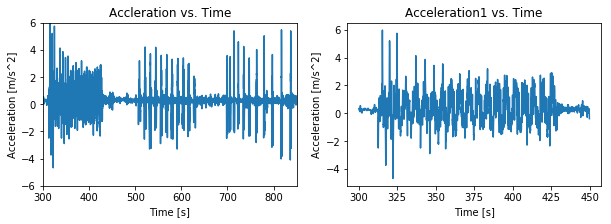

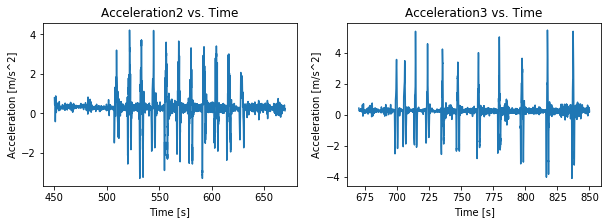

In [224]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list1 = []
acc_list2 = []
acc_list3 = []

gravity = -9.80665

#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array
time_array = time_e_array


#i = 0
#while (i < len(imu2_array)):
#    imu2_array[i] = imu2_array[i] - gravity
#    i = i + 1
#print(imu2_array)

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] > 300 and time_e_array[i] <= 450):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 450 and time_e_array[i] <= 670):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 670 and time_e_array[i] <= 850):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2


time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Accleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_xlim([300,850])
ax1.set_ylim([-6,6])

ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
#ax2.set_ylim([-6,6])

ax3.plot(time_array2, acc_array2)
ax3.set_title("Acceleration2 vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Acceleration [m/s^2]")
#ax3.set_ylim([-6,6])

ax4.plot(time_array3, acc_array3)
ax4.set_title("Acceleration3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Acceleration [m/s^2]")
#ax4.set_ylim([-6,6])

plt.show()
    

## PSD Step 2: Detrend the data 

In [225]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

##Remove outliers--points greater than 3x the standard deviation
std1 = np.std(dacc_array1)*3
std2 = np.std(dacc_array2)*3
std3 = np.std(dacc_array3)*3

#Returns a new array that is the same as the array passed in, with its outliers removed.
def removed_outliers(a_array, time_array, std):
    i = 0
    count = 0
    ret_accs = []
    ret_times = []
    while i < (len(a_array)):
        #if smaller than std, keep that value (larger ones get removed)
        if abs(a_array[i]) < std:
            ret_accs.append(a_array[i])
            ret_times.append(time_array[i])
        else:
            count = count + 1  #could help with debugging to know how many outliers removed
        i = i + 1  
    return count, ret_accs, ret_times;
        
count1, ro_array1, ro_time1 = removed_outliers(dacc_array1, time_array1, std1)
count2, ro_array2, ro_time2 = removed_outliers(dacc_array2, time_array2, std2)
count3, ro_array3, ro_time3 = removed_outliers(dacc_array3, time_array3, std3)

#print(len(dacc_array1))
#print(count1)
#print(len(ro_array1))

##Set up data interpolation (using Cubic Splines) for use in next step
cs1 = CubicSpline(ro_time1, ro_array1)
cs2 = CubicSpline(ro_time2, ro_array2)
cs3 = CubicSpline(ro_time3, ro_array3)


##interpld returns a function that relates y=ro_array (without outliers) to x=time:
#cs1 = interp1d(ro_time1, ro_array1)
#cs2 = interp1d(ro_time2, ro_array2)
#cs3 = interp1d(ro_time3, ro_array3)

#Now, use this interpolation to put points back into the original graph:
def add_interpolated_pts(a_array, time_array, std, cs):
    i = 0
    ret_acc = []
    while i < (len(a_array)):
        if abs(a_array[i]) > std:
            ret_acc.append(cs(time_array[i]))
        else:
            ret_acc.append(a_array[i])
        i = i + 1  
    return ret_acc;


#These are the new arrays with the interpolated points (which we will
#feed into a Kalman filter later).
interp_array1 = add_interpolated_pts(dacc_array1, time_array1, std1, cs1)
interp_array2 = add_interpolated_pts(dacc_array2, time_array2, std2, cs2)
interp_array3 = add_interpolated_pts(dacc_array3, time_array3, std3, cs3)


#print(len(interp_array1))
#print(len(dacc_array1))

##To verify that the two arrays are different(i.e. pts were actually interpolated):
j = 0
count = 0
while (j < (len(interp_array1) - 1)):
    if interp_array1[j] != dacc_array1[j]:
        count = count + 1
    j = j + 1
        
#print(count)
    

## Plot all of the data, to see visually:

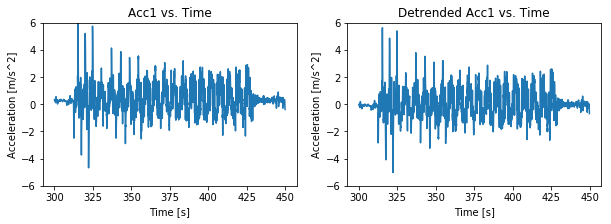

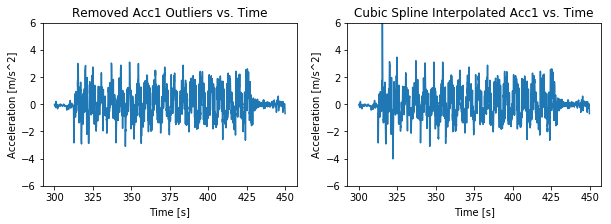

In [226]:
##Plotting the results for the 1st sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array1, acc_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])

ax2.plot(time_array1, dacc_array1)
ax2.set_title("Detrended Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

ax3.plot(ro_time1, ro_array1)
ax3.set_title('Removed Acc1 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])

ax4.plot(time_array1, interp_array1)
ax4.set_title("Cubic Spline Interpolated Acc1 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()

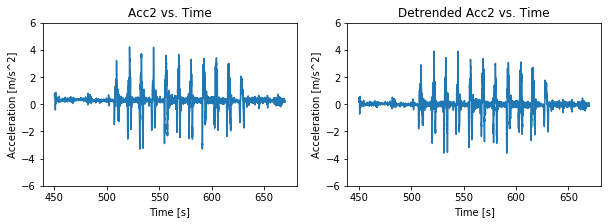

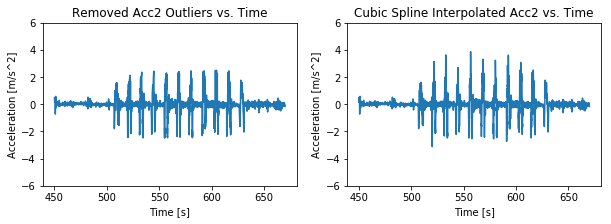

In [227]:
##Plotting the results for the 2nd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array2, acc_array2)
ax1.set_title('Acc2 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array2, dacc_array2)
ax2.set_title("Detrended Acc2 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time2, ro_array2)
ax3.set_title('Removed Acc2 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array2, interp_array2)
ax4.set_title("Cubic Spline Interpolated Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()




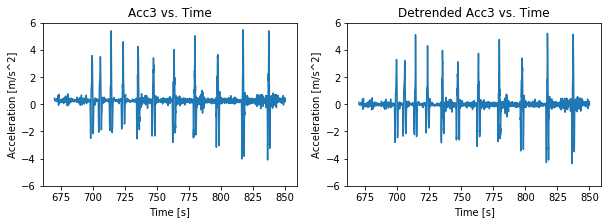

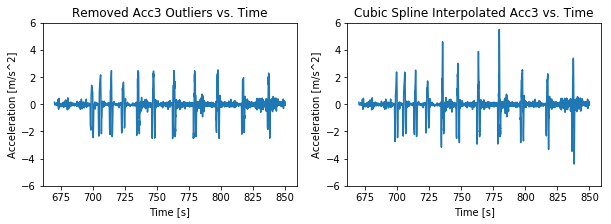

In [228]:
##Plotting the results for the 3rd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array3, acc_array3)
ax1.set_title('Acc3 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array3, dacc_array3)
ax2.set_title("Detrended Acc3 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time3, ro_array3)
ax3.set_title('Removed Acc3 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array3, interp_array3)
ax4.set_title("Cubic Spline Interpolated Acc3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()



Here, I'm implementing a lowess filter instead of a Kalman 
 filter right now because it seems simpler to implement.




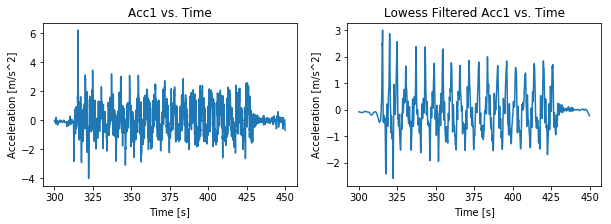

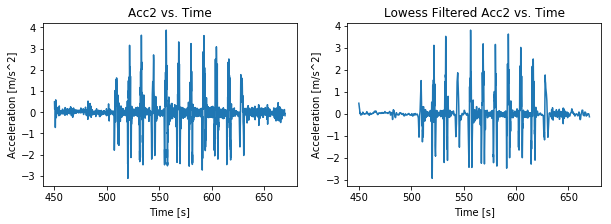

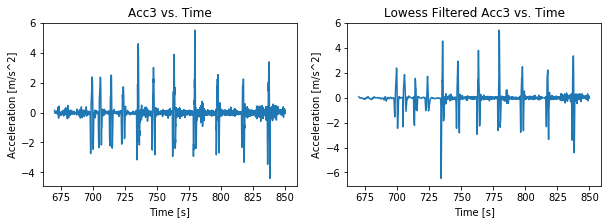

Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better 
 than the original.


In [229]:
##Now, feed interpolated arrays through a Kalman filter:
##(Actually I'm going to use a LOWESS filter for simplicity)

print("\n")
print("Here, I'm implementing a lowess filter instead of a Kalman \n filter right now because it seems simpler to implement.")
print("\n")

lowess = sm.nonparametric.lowess

#Parameters: takes in (y,x, ...)
filtered1 = lowess(interp_array1, time_array1, frac=0.005, is_sorted=True, return_sorted=False) 
filtered2 = lowess(interp_array2, time_array2, frac=0.002, is_sorted=True, return_sorted=False) 
filtered3 = lowess(interp_array3, time_array3, frac=0.002, is_sorted=True, return_sorted=False) 


##Plotting the filtered results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(time_array1, interp_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax2.plot(time_array1, filtered1)
ax2.set_title("Lowess Filtered Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc2
ax3.plot(time_array2, interp_array2)
ax3.set_title('Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(time_array2, filtered2)
ax4.set_title("Lowess Filtered Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc3
ax5.plot(time_array3, interp_array3)
ax5.set_title('Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(time_array3, filtered3)
ax6.set_title("Lowess Filtered Acc3 vs. Time")
ax6.set_xlabel("Time [s]")
ax6.set_ylabel('Acceleration [m/s^2]')

plt.show()

print("Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better \n than the original.")


## PSD Step 3: FFT of filtered data

Experiment Explanations:
Experiment1: We created 'waves' with amplitude of 1m and period of 6s.
We expect to see a peak at: 1/6s = 0.16 Hz.
Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.
We expect to see a peak at: 1/4s = 0.25 Hz.
Experiment3: We created 'waves' with amplitude of 1m and period of 2s.
We expect to see a peak at: 1/2s = 0.5. Hz.


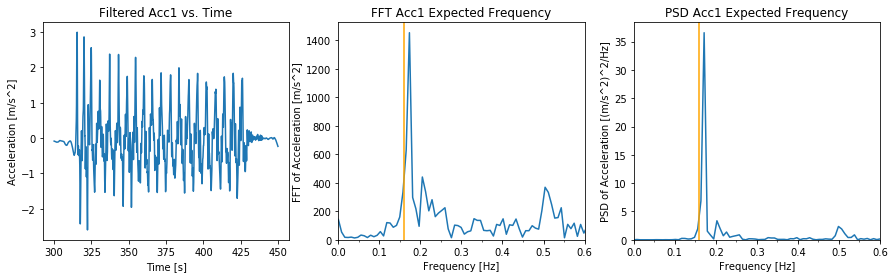

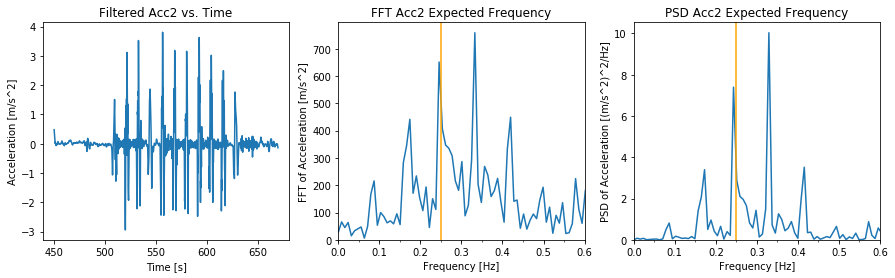

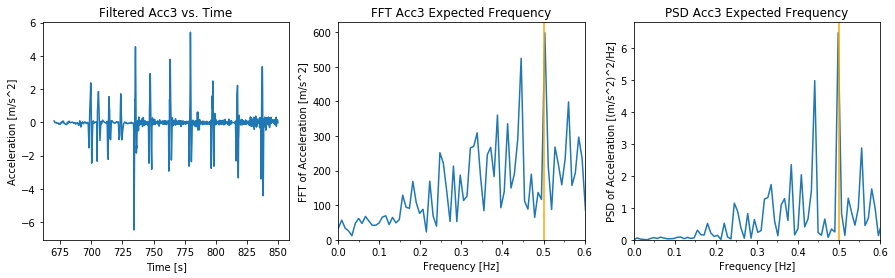

In [272]:
#First, need to fit the data so that the timestamps are *exactly* uniform

##PSD of filtered data
#psd1 = scipy.signal.periodogram(filtered1)
#psd2 = scipy.signal.periodogram(filtered2)
#psd3 = scipy.signal.periodogram(filtered3)

#These are just in case we have diff. rates later
#sampling_rate = 30
#inverse_sampling_rate = 1./sampling_rate
#timestep = inverse_sampling_rate

#For the 30Hz data we will just use timestep = 0.033
timestep = 0.033

fft1 = abs(np.fft.rfft(filtered1))
fft2 = abs(np.fft.rfft(filtered2))
fft3 = abs(np.fft.rfft(filtered3))

n1 = filtered1.size
n2 = filtered2.size
n3 = filtered3.size

fft_freq1 = np.fft.rfftfreq(n1, timestep)
fft_freq2 = np.fft.rfftfreq(n2, timestep)
fft_freq3 = np.fft.rfftfreq(n3, timestep)

#Here, we want to apply a low pass filter, and we only care about lower frequency signals (smaller than a
#frequency of 0.5 or 0.6)

#for x,y in zip(filtered1,fft1):
#    print(x)
#    print(y)

#for x in fft1:
#    print(x)

print("Experiment Explanations:")
print("Experiment1: We created 'waves' with amplitude of 1m and period of 6s.")
print("We expect to see a peak at: 1/6s = 0.16 Hz.")
print("Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.")
print("We expect to see a peak at: 1/4s = 0.25 Hz.")
print("Experiment3: We created 'waves' with amplitude of 1m and period of 2s.")
print("We expect to see a peak at: 1/2s = 0.5. Hz.")

##Calculating PSD graph:
#Can either estimate this by squaring the FFT or by using the python Periodogram function.

freq1, pxx1 = acc_psd1 = signal.periodogram(filtered1, fs=30, scaling='density')
freq2, pxx2 = acc_psd2 = signal.periodogram(filtered2, fs=30, scaling='density')
freq3, pxx3 = acc_psd3 = signal.periodogram(filtered3, fs=30, scaling='density')



##Plotting the psd results:
f1 = plt.figure(figsize=(15,4))
ax1 = f1.add_subplot(131)
ax2 = f1.add_subplot(132)
ax7 = f1.add_subplot(133)

f2 = plt.figure(figsize=(15,4))
ax3 = f2.add_subplot(131)
ax4 = f2.add_subplot(132)
ax8 = f2.add_subplot(133)

f3 = plt.figure(figsize=(15,4))
ax5 = f3.add_subplot(131)
ax6 = f3.add_subplot(132)
ax9 = f3.add_subplot(133)

##Subplots for acc1
ax1.plot(time_array1, filtered1)
ax1.set_title('Filtered Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax2.plot(fft_freq1, fft1)
ax2.set_title("FFT Acc1 Expected Frequency")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('FFT of Acceleration [m/s^2]')
ax2.set_xlim(0,0.6)
ax2.set_ylim(0,)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax2.axvline(0.16, color="orange")
ax7.plot(freq1, pxx1)
ax7.set_title("PSD Acc1 Expected Frequency")
ax7.set_xlabel("Frequency [Hz]")
ax7.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax7.set_xlim(0,0.6)
ax7.set_ylim(0,)
ax7.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax7.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax7.axvline(0.16, color="orange")



##Subplots for acc2
ax3.plot(time_array2, filtered2)
ax3.set_title('Filtered Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(fft_freq2, fft2)
ax4.set_title("FFT Acc2 Expected Frequency")
ax4.set_xlabel("Frequency [Hz]")
ax4.set_ylabel('FFT of Acceleration [m/s^2]')
ax4.set_xlim(0,0.6)
ax4.set_ylim(0,)
ax4.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax4.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax4.axvline(0.25, color="orange")
ax8.plot(freq2, pxx2)
ax8.set_title("PSD Acc2 Expected Frequency")
ax8.set_xlabel("Frequency [Hz]")
ax8.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax8.set_xlim(0,0.6)
ax8.set_ylim(0,)
ax8.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax8.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax8.axvline(0.25, color="orange")

##Subplots for acc3
ax5.plot(time_array3, filtered3)
ax5.set_title('Filtered Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(fft_freq3, fft3)
ax6.set_title("FFT Acc3 Expected Frequency")
ax6.set_xlabel("Frequency [Hz]")
ax6.set_ylabel('FFT of Acceleration [m/s^2]')
ax6.set_xlim(0,0.6)
ax6.set_ylim(0,)
ax6.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax6.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax6.axvline(0.5, color="orange")
ax9.plot(freq3, pxx3)
ax9.set_title("PSD Acc3 Expected Frequency")
ax9.set_xlabel("Frequency [Hz]")
ax9.set_ylabel('PSD of Acceleration [(m/s^2)^2/Hz]')
ax9.set_xlim(0,0.6)
ax9.set_ylim(0,)
ax9.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax9.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax9.axvline(0.5, color="orange")


plt.show()


#KaiserBessel window (based on the modified zero-order Bessel function) to reduce
#spectral leakage.

In [244]:
#Next steps: Noise-correct acceleration spectra
#1. Kaiser Bessel Window before FFT, and then post-processing of data
#2. Frequency Domain Filter to acceleration spectra to remove low-frequency noise
#   (modification of empirical noise correction of Lang 1987)





## Displacement Spectra:

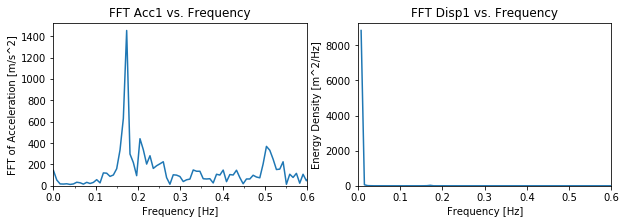

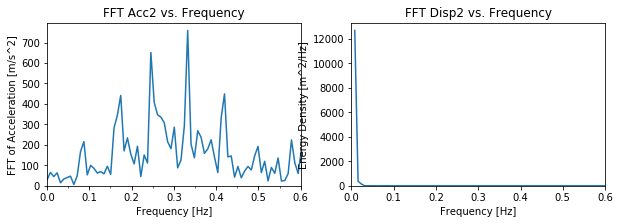

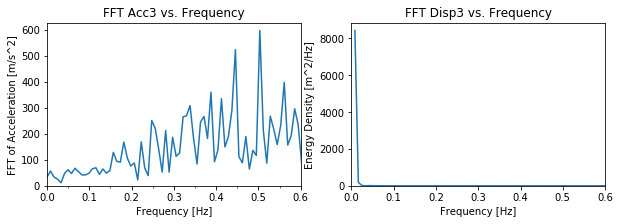

In [281]:
##Noise-corrected Acceleration spectra converted to displacement
##spectra by dividing by the frequency to the fourth power.

##Check to see if they're the same length:
#print(len(fft3))
#print(len(fft_freq3))

#for x in fft_freq3:
#    print(x**4)
    
##First attempt:   
##Iterate over the fft and freq lists to calculate new displacement spectra values.
samp_freq = 30

def calc_disp(fft, freq):
    fft = fft[1:] #Get rid of the first value, since fft_freq's first value is 0, and cannot divide by zero.
    freq = freq[1:]
    disp_spectra = []
    for x_fft, y_freq in zip(fft, freq):
        #"Normalizing" the PSD?
        new_d = float(x_fft**2/(samp_freq**4)) #Need to divide by 30**4 bc sampling freq?
        #new_d = float(x_fft/(y_freq**4)) #Using y_freq doesn't work
        #print(new_d)
        #print(y_freq)
        disp_spectra.append(new_d)
    return disp_spectra, freq

disp_spectra1, fft_nfreq1 = calc_disp(fft1, fft_freq1)
disp_spectra2, fft_nfreq2 = calc_disp(fft2, fft_freq2)
disp_spectra3, fft_nfreq3 = calc_disp(fft3, fft_freq3)



##Second attempt:

def calc_disp2(fft, freq):
    fft = fft[1:] #Get rid of the first value, since fft_freq's first value is 0, and cannot divide by zero.
    freq = freq[1:]
    disp_spectra = []
    for x_fft, y_freq in zip(fft, freq):
        omega = 2*math.pi*y_freq
        #new_d = float(x_fft/omega**2) #for FFT?
        new_d = float(x_fft/omega**4) #for PSD?
        disp_spectra.append(new_d)
    return disp_spectra, freq

#disp_spectra1, fft_nfreq1 = calc_disp2(fft1, fft_freq1)
#disp_spectra2, fft_nfreq2 = calc_disp2(fft2, fft_freq2)
#disp_spectra3, fft_nfreq3 = calc_disp2(fft3, fft_freq3)

##Attempt using PSD instead of FFT:
disp_spectra1, fft_nfreq1 = calc_disp2(pxx1, freq1)
disp_spectra2, fft_nfreq2 = calc_disp2(pxx2, freq2)
disp_spectra3, fft_nfreq3 = calc_disp2(pxx3, freq3)



#for x in disp_spectra1:
#    print(x)
    
    
#for x,y in zip(disp_spectra1, fft_nfreq1):
#    print(x,y)


#disp_spectra1 = np.array(disp_spectra1)

##Plotting the psd results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(fft_freq1, fft1)
ax1.set_title("FFT Acc1 vs. Frequency")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel('FFT of Acceleration [m/s^2]')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,)
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(plt.MultipleLocator(0.05))

ax2.plot(fft_nfreq1, disp_spectra1)
ax2.set_title('FFT Disp1 vs. Frequency')
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('Energy Density [m^2/Hz]')
ax2.set_xlim(0,0.6)
ax2.set_ylim(0,)


##Subplots for acc2
ax3.plot(fft_freq2, fft2)
ax3.set_title("FFT Acc2 vs. Frequency")
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel('FFT of Acceleration [m/s^2]')
ax3.set_xlim(0,0.6)
ax3.set_ylim(0,)
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax3.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax4.plot(fft_nfreq2, disp_spectra2)
ax4.set_title('FFT Disp2 vs. Frequency')
ax4.set_xlabel("Frequency [Hz]")
ax4.set_ylabel('Energy Density [m^2/Hz]')
ax4.set_xlim(0,0.6)
ax4.set_ylim(0,)

##Subplots for acc3
ax5.plot(fft_freq3, fft3)
ax5.set_title("FFT Acc3 vs. Frequency")
ax5.set_xlabel("Frequency [Hz]")
ax5.set_ylabel('FFT of Acceleration [m/s^2]')
ax5.set_xlim(0,0.6)
ax5.set_ylim(0,)
ax5.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax5.xaxis.set_minor_locator(plt.MultipleLocator(0.05))
ax6.plot(fft_nfreq3, disp_spectra3)
ax6.set_title('FFT Disp3 vs. Frequency')
ax6.set_xlabel("Frequency [Hz]")
ax6.set_ylabel('Energy Density [m^2/Hz]')
ax6.set_xlim(0,0.6)
ax6.set_ylim(0,)

plt.show()

## Calculating Wave Statistics:

In [279]:
#Print out the peak wave period: get the x-axis value at the peak y-axis value
peak_freq1 = fft_nfreq1[np.argmax(disp_spectra1)]
peak_freq2 = fft_nfreq2[np.argmax(disp_spectra2)]
peak_freq3 = fft_nfreq3[np.argmax(disp_spectra3)]

print("Calculating Peak Frequency:")
print("Expected near 0.16 Hz and got: ", peak_freq1, "Hz")
print("Expected near 0.25 Hz and got: ", peak_freq2, "Hz")
print("Expected near 0.5 Hz and got: ", peak_freq3, "Hz")


#Print out the peak wave frequency, which is 1/peak_period
peak_period1 = 1/peak_freq1
peak_period2 = 1/peak_freq2
peak_period3 = 1/peak_freq3

print("\n")
print("Calculating Peak Period:")
print("Expected near 6 secs and got: ", peak_period1, "secs")
print("Expected near 4 secs  and got: ", peak_period2, "secs")
print("Expected near 2 secs and got: ", peak_period3, "secs")

##Calculate the mean variance of the sea surface elevation, by taking the integral under the FFT curve
#We only want to integrate while fft_nfreq < 0.6:

def limit_frequency_range(fft_freq):
    ret_freq = []
    for x in fft_freq:
        if x < 0.6:
            ret_freq.append(x)
    return ret_freq

lim_freq1 = limit_frequency_range(fft_nfreq1)
lim_freq2 = limit_frequency_range(fft_nfreq2)
lim_freq3 = limit_frequency_range(fft_nfreq3)

#Need to make disp_spectra match length of newly limited frequency:
len1 = len(lim_freq1)
len2 = len(lim_freq2)
len3 = len(lim_freq3)

lim_dspectra1 = disp_spectra1[0:len1]
lim_dspectra2 = disp_spectra2[0:len2]
lim_dspectra3 = disp_spectra3[0:len3]

m0_1 = simps(y=lim_dspectra1, x=lim_freq1)
m0_2 = simps(y=lim_dspectra2, x=lim_freq2)
m0_3 = simps(y=lim_dspectra3, x=lim_freq3)

Hs1 = 4*math.sqrt(m0_1)
Hs2 = 4*math.sqrt(m0_2)
Hs3 = 4*math.sqrt(m0_3)

print("\n")
print("Calculating Significant Wave Heights:")
print("Expecting near 1m and got: ", Hs1, "[m]")
print("Expecting near 1.5m and got: ", Hs2, "[m]")
print("Expecting near 1m and got: ", Hs3, "[m]")


#Calculate the significant wave height by taking 4*sqrt(mean_variance^2)

Calculating Peak Frequency:
Expected near 0.16 Hz and got:  0.171473109899 Hz
Expected near 0.25 Hz and got:  0.00784108729744 Hz
Expected near 0.5 Hz and got:  0.00816771031854 Hz


Calculating Peak Period:
Expected near 6 secs and got:  5.83181818182 secs
Expected near 4 secs  and got:  127.533333333 secs
Expected near 2 secs and got:  122.433333333 secs


Calculating Significant Wave Heights:
Expecting near 1m and got:  2.7635610819575316 [m]
Expecting near 1.5m and got:  2.46046649806927 [m]
Expecting near 1m and got:  1.715199867725086 [m]
